In [ ]:
!pip install wget

# Avoid Overfitting using Regularization

In [2]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)

# for the purpose of reproduce
SEED = 0
seed_all(SEED)

## Load Dataset

In [ ]:
!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv

In [4]:
DELANEY_FILE = "delaney-processed.csv"
TASK_COL = 'measured log solubility in mols per litre'
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


In [5]:
df

Compound ID  ESOL predicted log solubility in mols per litre  \
0          Amigdalin                                           -0.974   
1           Fenfuram                                           -2.885   
2             citral                                           -2.579   
3             Picene                                           -6.618   
4          Thiophene                                           -2.232   
...              ...                                              ...   
1123       halothane                                           -2.608   
1124          Oxamyl                                           -0.908   
1125       Thiometon                                           -3.323   
1126  2-Methylbutane                                           -2.245   
1127        Stirofos                                           -4.320   

      Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
0                  1           457.432                        7   
1                  1           201.225                        1   
2                  1           152.237                        0   
3                  2           278.354                        0   
4                  2            84.143                        0   
...              ...               ...                      ...   
1123               1           197.381                        0   
1124               1           219.266                        1   
1125               1           246.359                        0   
1126               1            72.151                        0   
1127               1           365.964                        0   

      Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
0                   3                          7              202.32   
1                   2                          2               42.24   
2                   0                          4               17.07   
3                   5                          0                0.00   
4                   1                          0                0.00   
...               ...                        ...                 ...   
1123                0                          0                0.00   
1124                0                          1               71.00   
1125                0                          7               18.46   
1126                0                          1                0.00   
1127                1                          5               44.76   

      measured log solubility in mols per litre  \
0                                        -0.770   
1                                        -3.300   
2                                        -2.060   
3                                        -7.870   
4                                        -1.330   
...                                         ...   
1123                                     -1.710   
1124                                      0.106   
1125                                     -3.091   
1126                                     -3.180   
1127                                     -4.522   

                                                 smiles  
0     OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...  
1                                Cc1occc1C(=O)Nc2ccccc2  
2                                  CC(C)=CCCC(C)=CC(=O)  
3                    c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43  
4                                               c1ccsc1  
...                                                 ...  
1123                                   FC(F)(F)C(Cl)Br   
1124                          CNC(=O)ON=C(SC)C(=O)N(C)C  
1125                                  CCSCCSP(=S)(OC)OC  
1126                                            CCC(C)C  
1127              COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl  

[1128 rows x 10 columns]

## Polynomial Fitting

In [6]:
X = df[["Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds"]].values
y = df[TASK_COL].values.reshape(-1, 1)

In [7]:
test_size = int(len(X)*0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

In [8]:
def run_gd(X_train, y_train, X_test, y_test, lr, M,
           n_epochs=20, normalize=True, norm=None,
           lamda=1, init="zero", return_mse=True):
    assert init in ["zero", "random"]
    theta_list = []
    loss_list = []
    loss_test_list = []
    if return_mse:
        mse_list = []
        mse_test_list = []

    poly_features = PolynomialFeatures(degree=M)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)

    if normalize:
        scaler = StandardScaler()
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_test_poly = scaler.transform(X_test_poly)
    else:
        scaler = None

    X_train_poly = np.hstack([np.ones((X_train_poly.shape[0], 1)), X_train_poly])
    X_test_poly = np.hstack([np.ones((X_test_poly.shape[0], 1)), X_test_poly])

    if init == "zero":
        theta = np.zeros(X_train_poly.shape[1]).reshape(-1, 1)
    else:
        theta = np.random.randn(X_train_poly.shape[1]).reshape(-1, 1)

    # gd fit
    for _ in range(n_epochs):
        theta_list.append(copy.deepcopy(theta))

        y_pred = X_train_poly @ theta
        loss = np.mean((y_pred - y_train).reshape(-1)**2)
        if return_mse:
            mse_list.append(loss)
        if norm is None:
            loss = loss
        elif norm == "l1":
            loss += lamda*np.sum(np.abs(theta))
        elif norm == "l2":
            loss += lamda*np.sum(theta**2)
        else:
            NotImplementedError(f"Norm {norm} is not valid normalization method")
        loss_list.append(loss)
        grad = 2*X_train_poly.T @ (X_train_poly @ theta - y_train) / y_train.shape[0]
        if norm is None:
            grad = grad
        elif norm == "l1":
            grad += lamda*np.sign(theta)
        elif norm == "l2":
            grad += lamda*2*theta
        else:
            raise NotImplementedError(f"Norm {norm} is not valid normalization method")

        theta = theta - lr * grad

        # predict and calculate rmse of test dataset
        y_test_pred = X_test_poly @ theta
        loss_test = np.mean((y_test_pred-y_test).reshape(-1)**2)
        if return_mse:
            mse_test_list.append(loss_test)
        if norm is None:
            loss_test = loss_test
        elif norm == "l1":
            loss_test += lamda*np.sum(np.abs(theta))
        elif norm == "l2":
            loss_test += lamda*np.sum(theta**2)
        else:
            NotImplementedError(f"Norm {norm} is not valid normalization method")
        loss_test_list.append(loss_test)
    if return_mse:
        return theta_list, mse_list, mse_test_list, scaler
    else:
        return theta_list, loss_list, loss_test_list, scaler

## Without Regularization

In [9]:
lr = 5e-3
n_epochs = 1500
normalize = True
norm = None # regularization in GD

orders = [0, 1, 2, 3, 4, 5]
results = {}

for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test, lr, M, n_epochs, normalize)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

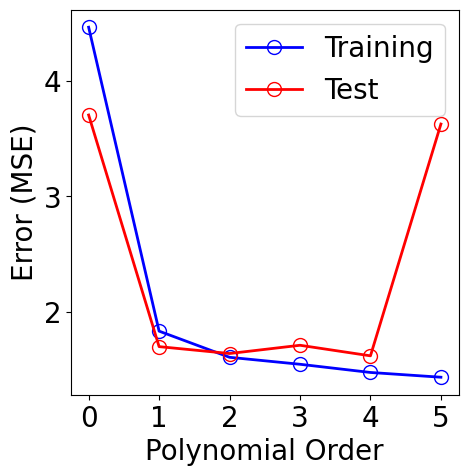

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(orders, [results[M][1][-1] for M in orders], "-", color="b",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", label="Training")
plt.plot(orders, [results[M][2][-1] for M in orders], "-", color="r",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r", label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Error (MSE)")
plt.xticks(orders)
plt.legend()

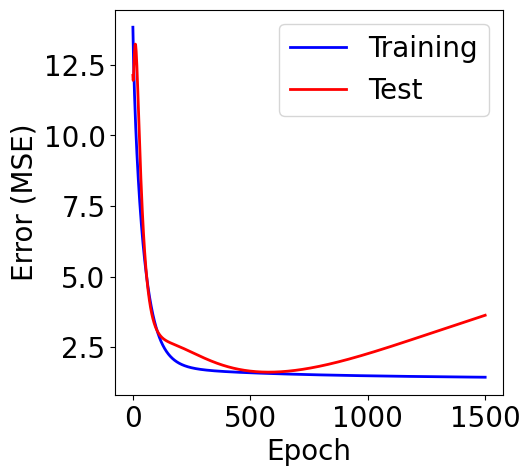

In [11]:
M = orders[-1]
theta_list, loss_list, loss_test_list, scaler = results[M]

f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Error (MSE)")
plt.legend()

## L2 Norm

In [12]:
normalize = True
norm = "l2" # regularization in GD
lamda = 1

results = {}


for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test,
                                                           lr, M, n_epochs, normalize, norm=norm, lamda=lamda)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

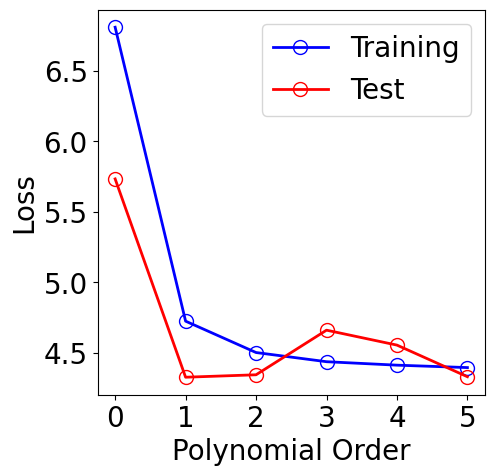

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(orders, [results[M][1][-1] for M in orders], "-", color="b",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", label="Training")
plt.plot(orders, [results[M][2][-1] for M in orders], "-", color="r",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r", label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Loss")
plt.xticks(orders)
plt.legend()

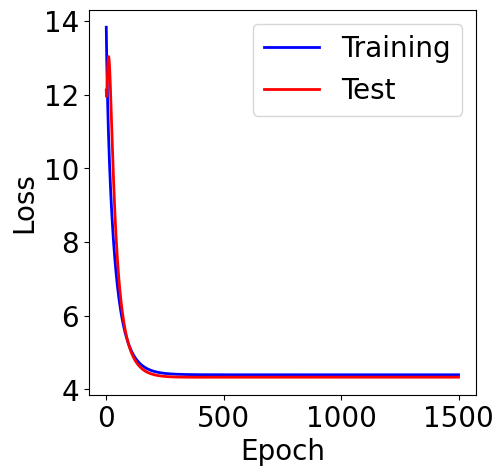

In [14]:
M = orders[-1]
theta_list, loss_list, loss_test_list, scaler = results[M]

f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## L1 Norm

In [15]:
normalize = True
norm = "l1" # regularization in GD
lamda = 1

results = {}

for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test,
                                                           lr, M, n_epochs, normalize, norm=norm, lamda=lamda)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

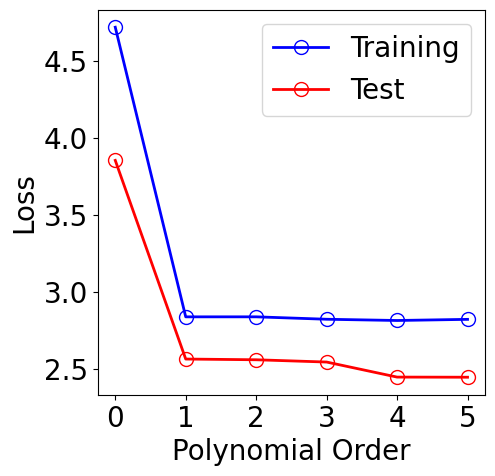

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(orders, [results[M][1][-1] for M in orders], "-", color="b",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", label="Training")
plt.plot(orders, [results[M][2][-1] for M in orders], "-", color="r",
         marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r", label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Loss")
plt.xticks(orders)
plt.legend()

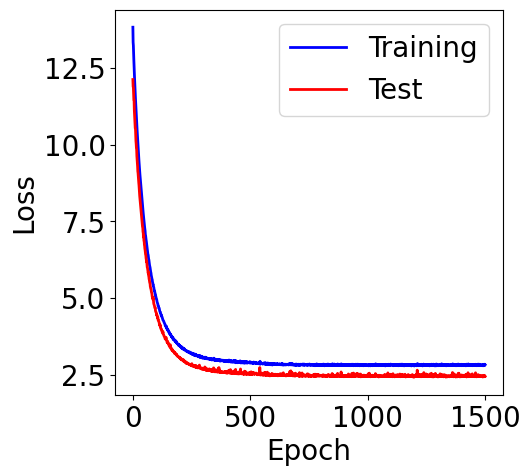

In [17]:
M = orders[-1]
theta_list, loss_list, loss_test_list, scaler = results[M]

f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()